In [21]:
import glob, sys, os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings(action = 'ignore')
import zipfile
import pandas as pd

# 1. 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/data/HuBAP/hubmap-organ-segmentation.zip'
file1= zipfile.ZipFile(path, 'r')
file1.extractall('/content/drive/MyDrive/data/HuBAP/hubmap-organ-segmentation')

In [34]:
# get train_annotations
import json

ann_paths = glob.glob('/content/drive/MyDrive/data/HuBAP/hubmap-organ-segmentation/train_annotations/*json')
anns = []
for path in ann_paths :
    with open(path) as f:
        ann = json.load(f)
        ann = np.array(ann)
        anns.append(ann)
anns = np.array(anns)
print(anns.shape)

(351,)


In [30]:
# get input images as array 

img_paths = glob.glob('/content/drive/MyDrive/data/HuBAP/hubmap-organ-segmentation/train_images/*tiff')
imgs = []
h,w = 512,512
for i in img_paths :
    img = Image.open(i).resize((h,w))
    img = np.asarray(img)
    imgs.append(img)
    
imgs = np.array(imgs)
print(imgs.shape)

(351, 512, 512, 3)


In [22]:
# get train_csv

df_train = pd.read_csv('/content/drive/MyDrive/data/HuBAP/hubmap-organ-segmentation/train.csv')
df_train.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [23]:
df_train['organ'].unique()

array(['prostate', 'spleen', 'lung', 'kidney', 'largeintestine'],
      dtype=object)

In [25]:
df_train['tissue_thickness'].unique()

array([4])

## organ(장기)
* prostate : 전립선
* spleen : 비장
* lung : 폐
* kidney : 신장
* largeintestine : 대장

## rle : run lengh encoding

# 2. 런-렝스 부호화 디코딩

In [70]:
# rle 값 확인 -> 시작점 길이 시작점 길이 시작점 길이.... 형식으로 이루어져 있음.
df_train['rle'][0]

'1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 105 1480665 109 1483664 115 1486662 119 1489661 121 1492659 125 1495658 127 1498656 131 1501655 133 1504653 137 1507652 139 1510651 140 1513650 142 1516649 143 1519648 145 1522647 146 1525646 148 1528645 149 1531644 151 1534643 152 1537642 153 1540641 155 1543640 156 1546639 157 1549638 158 1552637 160 1555636 161 1558635 162 1561634 163 1564633 165 1567631 167 1570628 171 1573625 175 1576622 179 1579620 182 1582619 184 1585618 186 1588617 188 1591616 190 1594615 191 1597615 191 1600614 192 1603613 193 1606612 194 1609611 195 1612610 196 1615609 197 1618607 200 1621606 202 1624604 205 1627603 207 1630601 211 1633600 213 1636599 215 1639597 218 1642596 220 1645594 223 1648592 226 1651590 228 1654588 230 1657586 232 1660584 234 1663582 236 1666580 238 1669578 240 1672577 241 1675576 242 1678575 244 1681574 245 1684573 246 1687572 248 1690571 249 1693570 250 1696569 252 1699568 253 1702567 254 1705566 256 1708566 

In [91]:
# 시작점과 끝나는점 리턴하는 함수 생성
def Rle_split(rle) :
  n = np.array(rle.split(' '), dtype = int)
  start = n[::2]
  lengths = n[1::2]
  end = start+lengths
  return start,end

In [112]:
# 백지 만들고 mask에 해당하는 부분 그리도록 하는 함수 생성
def Draw(shape, start, end, color) :
  if len(shape) == 3 :
    h,w,c = shape
    white = np.zeros((h*w,c), dtype = np.float32)
  else :
    h,w = shape
    white = np.zeros((h*w), dtype = np.float32)

  for s,e in zip(start,end) :
    white[s:e] = color
  return white.reshape(shape).T

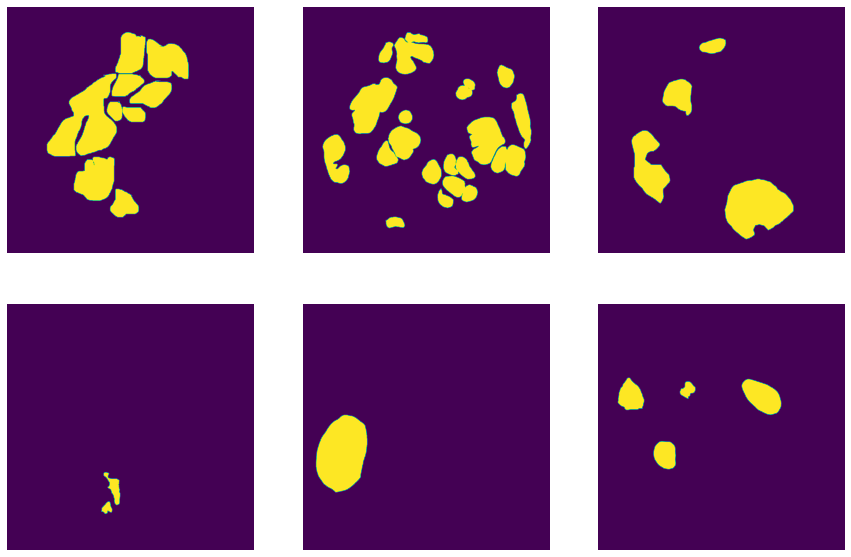

In [125]:
plt.figure(figsize=(15,10))
for i in range(6) :
  rle = df_train['rle'][i]
  start, end = Rle_split(rle)
  a = Draw((3000,3000), start, end, 1)
  plt.subplot(2,3,i+1)
  # plt.xticks([]);plt.yticks([])
  plt.axis("off")
  plt.imshow(a)

# 3. 데이터 시각화

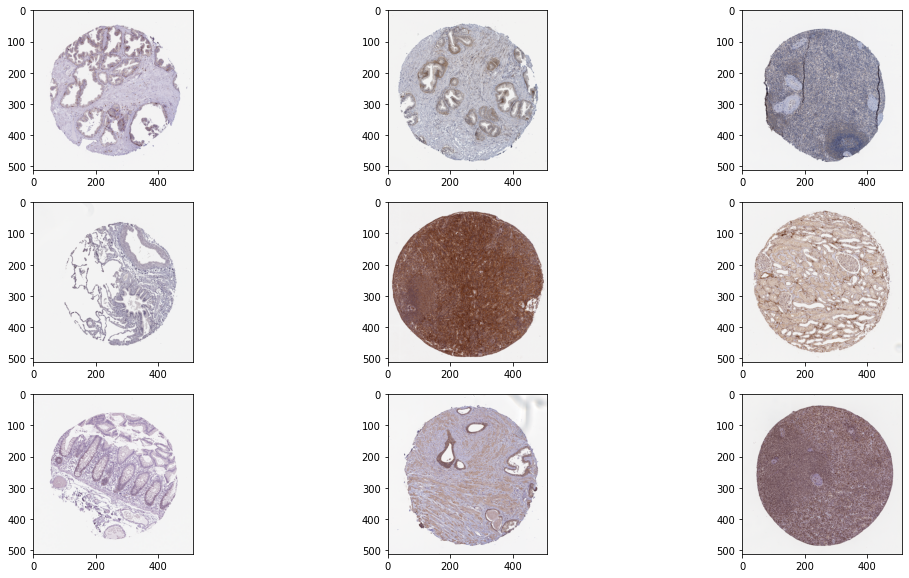

In [32]:
plt.figure(figsize = (18,10))
for i in range(0,9) :
  plt.subplot(3,3,i+1)
  plt.imshow(imgs[i])
plt.show()

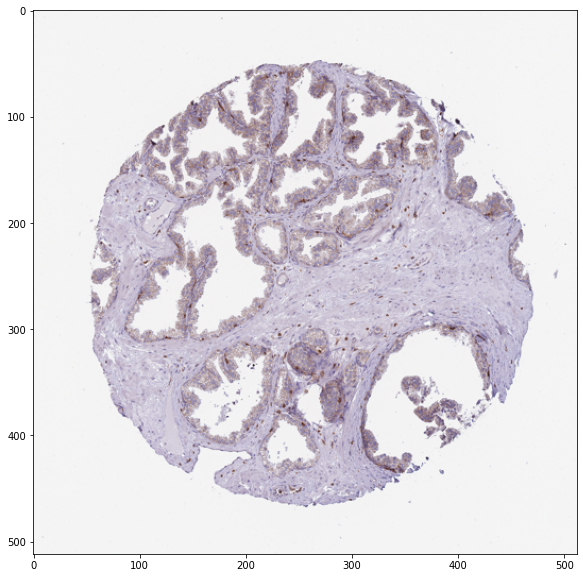

In [39]:
plt.figure(figsize = (18,10))
plt.imshow(imgs[0])
plt.show()

In [131]:
mask_img = []
for i in range(len(df_train)) :
  rle = df_train['rle'][i]
  n = (h*w) / (3000*3000)  # h : height, w : width
  start, end = Rle_split(rle)
  start = start * n
  end = end * n
  mask = Draw((h,w), start, end, 1)
  mask_img.append(mask)
np.asarray(mask_img)
print(mask_img.shape)

TypeError: ignored

34.332275390625